### 总结：Quantum Variational Autoencoder（QVAE）原理与代码实现

---

## 一、QVAE 原理概括

QVAE（Quantum Variational Autoencoder）是一种将 **量子生成模型** 引入 **变分自编码器(VAE)** 潜空间的生成模型。其核心思想是：

> **用量子玻尔兹曼机（QBM）替代传统VAE中的先验分布，从而构建一个具有量子生成能力的潜变量模型。**

### 模型结构

QVAE 包括以下关键组件：

1. **编码器（Encoder）**：  
   将输入数据 x 映射为潜变量的近似后验分布  
   $q_\phi(z|x)$，通常由神经网络参数化。

2. **先验分布（Prior）**：  
   使用 **量子玻尔兹曼机(QBM)** 建模潜变量 z 的先验分布。哈密顿量为：  
   $$
   \mathcal{H}_\theta = \sum_l \Gamma_l \sigma_l^x + \sum_l h_l \sigma_l^z + \sum_{l<m} W_{lm} \sigma_l^z \sigma_m^z
   $$

3. **解码器（Decoder）**：  
   将潜变量 z（或其连续松弛变量 $\zeta$）映射回数据空间，并使用解码器重建原始数据：  
   $$
   p_\theta(\mathbf{x} | \boldsymbol{\zeta}) \approx \text{Bernoulli}(f_\theta(\boldsymbol{\zeta}))
   $$

### 训练目标：Q-ELBO

QVAE 使用一个 **量子下界(Q-ELBO)** 来近似最大化对数似然：

$$
\mathcal{L}_{\text{Q-ELBO}} = \mathbb{E}_{q_\phi(\mathbf{z}|\mathbf{x})} [\log p_\theta(\mathbf{x} | \boldsymbol{\zeta})] - \tilde{H}(q_\phi(\mathbf{z}|\mathbf{x}) \| p_\theta(\mathbf{z}))
$$

### QBM采样与训练

- **正相（positive phase）**：从编码器采样  $z \sim q_\phi(z|x)$
- **负相（negative phase）**：从 QBM 中采样 $z \sim p_\theta(z)$，使用 **蒙特卡洛方法** 或 **量子退火器**
把能量作为目标函数，objective的梯度即为基于正相和负相采样计算的梯度

## 二、代码架构概述

```bash

QVAE 完整训练流程
│
├── 1. 数据准备 (setup_data_loaders)
│   ├── MNIST数据集加载
│   ├── 图像展平预处理 (784维向量)
│   └── 训练/测试集划分
│
├── 2. 模型构建 (QVAE)
│   ├── 编码器 (Encoder)
│   ├── 解码器 (Decoder) 
│   └── RBM先验 (RestrictedBoltzmannMachine)
│
├── 3. 训练监控 (train_qvae_with_tsne)
│   ├── 前向传播 (neg_elbo计算)
│   ├── 反向传播 (梯度更新)
│   ├── t-SNE可视化跟踪
│   └── 训练动态动画生成
│
├── 4. 图像生成
│   ├── 原始图像可视化
│   ├── 重构质量评估
│   └── 新样本生成
│
└── 5. 质量评估
    └── FID分数计算
```


## 三、代码内容概括

该例子实现了一个 **基于 MNIST 的 QVAE 训练流程**，包括以下模块：


### 模型构建

- 使用自定义 `QVAE` 类：
  - 编码器/解码器为全连接网络；
  - 使用 `mean_x` 作为模型偏移量；
  - 包含玻尔兹曼机作为先验分布

### 训练过程

- 优化器：Adam，学习率 1e-3；
- 损失函数：`loss = neg_elbo + wd_loss`，即包含ELBO下界和weight decay
- 每个 epoch 保存模型权重；
- 记录并保存以下历史数据：
  - `loss_history`
  - `elbo_history`
  - `kl_history`
  - `cost_history`


### 图像生成流程

1. 从 RBM 中采样潜变量 `z`；
2. 引入平滑分布 `Exponential(beta)` 采样 `zeta`；
3. 使用解码器生成图像：
   $$
   \text{generated\_x} = \sigma(\text{decoder}(zeta) + \text{train\_bias})
   $$

### FID 评估

- 使用 `torchmetrics.image.fid.FrechetInceptionDistance`；
- 提供函数：
  - `get_real_images()`：从验证集获取真实图像；
  - `generate_images_qvae()`：使用 QVAE 生成图像；
  - `compute_fid_in_batches()`：计算 FID 分数（适配 MNIST）；
- 最终输出 QVAE 在 MNIST 上的 FID 分数。



## 四、总结

> QVAE = VAE 的编码器/解码器 + QBM 的量子先验，通过最大化量子下界（Q-ELBO）实现端到端训练；  
> 代码包含MNIST 数据集，QVAE 模型，训练循环，图像可视化和FID 评估，完整实现了量子自编码器模型的实验流程。

In [1]:
import os
import torch
from datetime import datetime
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from kaiwu.classical import SimulatedAnnealingOptimizer
from kaiwu.torch_plugin import RestrictedBoltzmannMachine, QVAE
from utils import Encoder, Decoder, save_list_to_txt
from visualizers import t_SNE, create_tsne_animation
# from models import MLP, LogisticRegression

model_name = "QVAE_annealing_tanh"
save_path = f"./models/{model_name}"
os.makedirs(save_path, exist_ok=True)

# 添加kaiwu的license信息


# MNIST数据集加载

In [2]:
# 定义数据转换操作
def flatten_tensor(x):
    return x.view(-1)

def setup_data_loaders(root, download=True, batch_size=256, use_cuda=False):
    """
    设置MNIST数据集的数据加载器
    
    Args:
        root (str): 数据存储根目录
        download (bool): 如果数据不存在是否下载，默认为True
        batch_size (int): 每个批次的样本数量，默认为128
        use_cuda (bool): 是否使用GPU，决定是否启用pin_memory优化
    
    Returns:
        tuple: (train_loader, test_loader) 训练和测试数据加载器
    """
    # 数据预处理管道
    transform = transforms.Compose([
        transforms.ToTensor(),             # 转换为Tensor
        transforms.Lambda(flatten_tensor)  # 展平：将28x28图像展平成784维向量
        # 等效于：x.reshape(-1) 或 x.flatten()
    ])
    
    # 加载训练集
    train_set = datasets.MNIST(
        root=root,           # 数据存储路径
        train=True,          # 加载训练集（共60000个样本）
        transform=transform, # 应用定义的数据变换
        download=download    # 如果数据不存在则自动下载
    )
    
    # 加载测试集
    test_set = datasets.MNIST(
        root=root,           # 数据存储路径  
        train=False,         # 加载测试集（共10000个样本）
        transform=transform  # 应用相同的数据变换
    )

    # 数据加载器配置参数
    # 根据是否使用GPU选择不同的优化参数
    # 将num_workers设为0避免多进程问题
    kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {'num_workers': 0}

    # 创建训练数据加载器
    train_loader = DataLoader(
        dataset=train_set,     # 训练数据集
        batch_size=batch_size, # 每个批次的样本数
        shuffle=True,          # 每个epoch打乱数据顺序，防止模型记忆顺序
        **kwargs               # 解包上述配置参数
    )
    
    # 创建测试数据加载器
    test_loader = DataLoader(
        dataset=test_set,      # 测试数据集
        batch_size=batch_size, # 批次大小（通常与训练集相同）
        shuffle=False,         # 测试集不需要打乱，保证可重复性
        **kwargs               # 解包配置参数
    )

    return train_loader, test_loader

In [3]:
def train_qvae_with_tsne(
    train_loader,           # 用于训练QVAE
    test_loader,            # 用于t-SNE可视化测试数据
    device,
    tsne_interval=1,        # 每隔多少个epoch做一次t-SNE
    animation_save_path="qva_training_evolution.gif",
    # VAE部分参数
    input_dim = 784,        # 图片拉伸后的维度
    hidden_dim = 512,       # fc1压缩后的维度
    latent_dim = 256,       # 隐变量维度， num_visible + num_hidden
    num_var1 = 128,         # RBM可见层维度
    num_var2 = 128,         # RBM藏层维度
    dist_beta = 10,         # 重叠分布的beta
    batch_size=256,
    epochs=20,
    lr=1e-3,
    kl_beta = 0.000001
):   
    # 创建保存临时图像的文件夹
    os.makedirs("temp_tsne_frames", exist_ok=True)
    tsne_frames = []

    # 计算数据均值
    mean_x = 0
    for x, _ in train_loader:
        mean_x += x.mean(dim=0)
    mean_x = mean_x / len(train_loader)
    mean_x = mean_x.cpu().numpy()

    # 创建编码器、解码器
    encoder = Encoder(input_dim, hidden_dim, latent_dim, weight_decay=0.01)
    decoder = Decoder(latent_dim, hidden_dim, input_dim, weight_decay=0.01)

    # 初始化bm和sampler
    rbm = RestrictedBoltzmannMachine(
        num_visible=num_var1, 
        num_hidden=num_var2, 
        h_range=[-1, 1], 
        j_range=[-1, 1]
    )
    sampler = SimulatedAnnealingOptimizer(alpha=0.95)

    # 创建Q-VAE模型
    model = QVAE(
        encoder=encoder,
        decoder=decoder,
        bm=rbm, 
        sampler=sampler, 
        dist_beta=dist_beta, 
        mean_x=mean_x, 
        num_vis=num_var1
    ).to(device)

    # 优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 训练循环
    loss_history = []
    elbo_history = []
    kl_history = []
    cost_history = []

    model.train()  # 设置模型为训练模式
    for epoch in tqdm(range(1, epochs)):  # 遍历每个训练轮次
        total_loss, total_elbo, total_kl, total_cost = 0, 0, 0, 0  # 初始化本轮累计损失等指标
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)  # 将输入数据移动到指定设备（CPU/GPU）
            optimizer.zero_grad()  # 梯度清零

            # 前向传播，计算负ELBO、权重衰减、KL散度等
            output, recon_x, neg_elbo, wd_loss, kl, cost, _, _ = model.neg_elbo(data, kl_beta)
            loss = neg_elbo + wd_loss  # 总损失 = 负ELBO + 权重衰减
            loss.backward()  # 反向传播，计算梯度

            optimizer.step()  # 更新模型参数

            # 累加本批次的各项指标
            total_loss += loss.item()
            total_elbo += neg_elbo.item()
            total_kl += kl.item()
            total_cost += cost.item()

        # 计算本轮各项指标的平均值
        avg_loss = total_loss / len(train_loader)
        avg_elbo = total_elbo / len(train_loader)
        avg_kl = total_kl / len(train_loader)
        avg_cost = total_cost / len(train_loader)

        # 记录历史指标
        loss_history.append(avg_loss)
        elbo_history.append(avg_elbo)
        kl_history.append(avg_kl)
        cost_history.append(avg_cost)
        
        save_list_to_txt(os.path.join(save_path, "loss_history.txt"), loss_history)
        save_list_to_txt(os.path.join(save_path, "elbo_history.txt"), elbo_history)
        save_list_to_txt(os.path.join(save_path, "cost_history.txt"), cost_history)
        save_list_to_txt(os.path.join(save_path, "kl_history.txt"), kl_history)
        
        # # 保存当前轮次的模型参数
        # model_save_path = os.path.join(save_path, f'davepp_epoch{epoch}.pth')
        # torch.save(model.state_dict(), model_save_path)

        # 打印本轮训练结果
        print(f"Epoch {epoch}/{epochs}: Loss: {avg_loss:.4f}, elbo: {avg_elbo:.4f}, KL: {avg_kl:.4f}, Cost: {avg_cost:.4f}")

        # 每隔tsne_interval个epoch做一次t-SNE
        if epoch % tsne_interval == 0 or epoch == epochs:
            print(f"Generating t-SNE visualization for epoch {epoch}...")
            
            # 生成t-SNE图像
            frame_path = f"temp_tsne_frames/tsne_epoch_{epoch:03d}.png"
            # frame_path = os.path.join(save_path, f"temp_tsne_frames/tsne_epoch_{epoch:03d}.png")
            _ = t_SNE(
                test_loader, 
                model, 
                epochs=epoch,  # 传入当前epoch
                save_path=frame_path,
                show=False  # 训练过程中不显示，只保存
            )
            tsne_frames.append(frame_path)
    
    # 生成动画
    print("Creating training evolution animation...")
    create_tsne_animation(tsne_frames, animation_save_path)
    
    # 清理临时文件
    for frame in tsne_frames:
        if os.path.exists(frame):
            os.remove(frame)
    os.rmdir("temp_tsne_frames")

    # 保存模型
    model_save_path = os.path.join(save_path, f'qvae_mnist.pth')
    torch.save(model.state_dict(), model_save_path)
    return model 

Training Q-VAE with t-SNE visualization...


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Epoch 1/2: Loss: 201.8112, elbo: 201.8107, KL: -98.8200, Cost: 201.8108
Generating t-SNE visualization for epoch 1...
Extracted 10000 samples with 256 dimensions
Running t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.004s...
[t-SNE] Computed neighbors for 10000 samples in 0.363s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE]

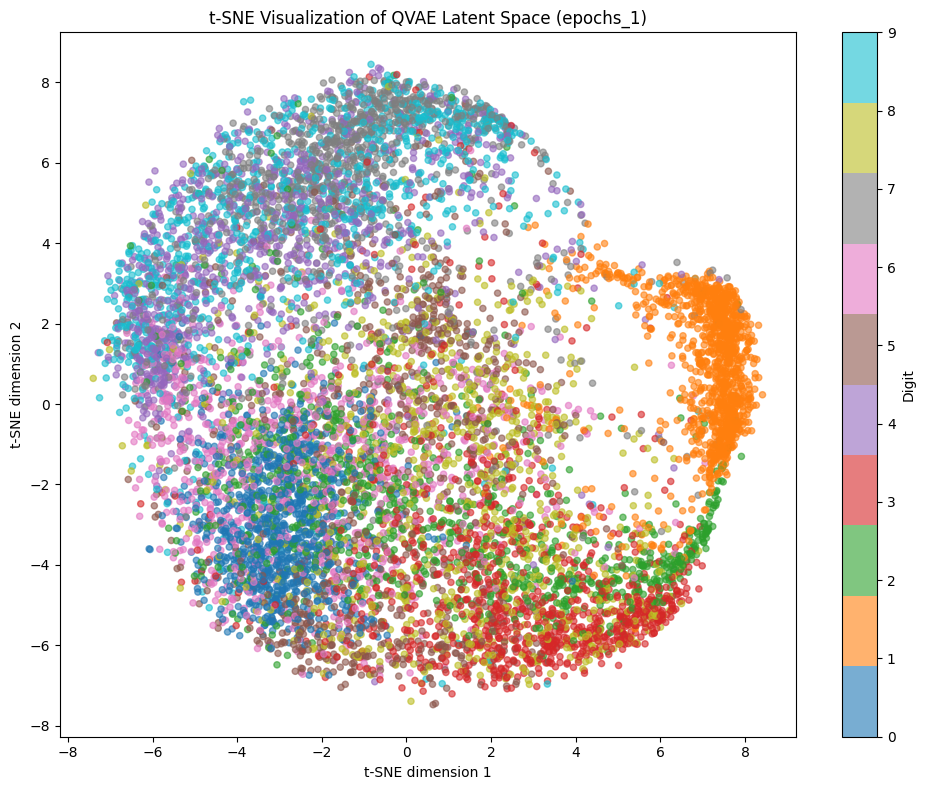

100%|█████████████████████████████████████████████| 1/1 [00:34<00:00, 34.27s/it]


Creating training evolution animation...
Training evolution animation saved to: ./models/QVAE_annealing_tanh/qva_training_evolution.gif
Animation contains 1 frames, all with shape (2365, 2776, 4)

Generating final high-quality t-SNE visualization...

Extracted 10000 samples with 256 dimensions
Running t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.004s...
[t-SNE] Computed neighbors for 10000 samples in 0.266s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] C

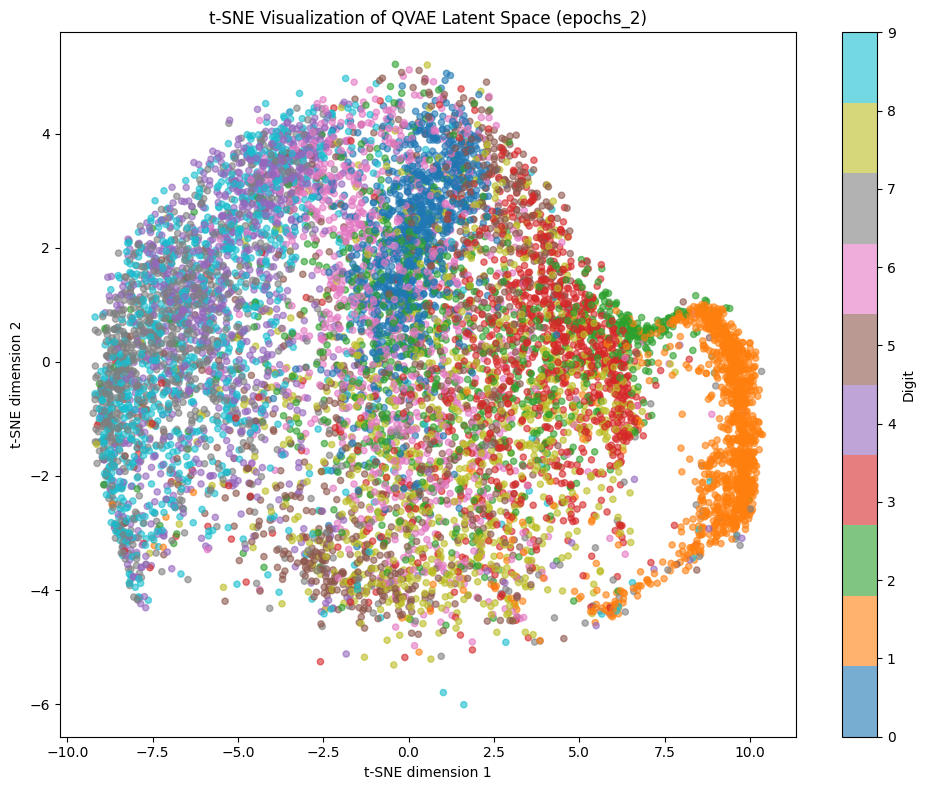


=== 图像生成和重构可视化 ===
可视化原始图像，保存到: ./models/QVAE_annealing_tanh/original.png
图像已保存到: ./models/QVAE_annealing_tanh/original.png
可视化重构图像，保存到: ./models/QVAE_annealing_tanh/recon_x.png
图像已保存到: ./models/QVAE_annealing_tanh/recon_x.png

=== 生成新图像 ===
可视化生成图像，保存到: ./models/QVAE_annealing_tanh/generated_x.png
图像已保存到: ./models/QVAE_annealing_tanh/generated_x.png

=== FID评估 ===
获取真实图像...
Real images shape: torch.Size([10000, 784])

生成QVAE图像...


100%|█████████████████████████████████████████| 156/156 [00:07<00:00, 21.82it/s]


Generated images shape: torch.Size([10000, 784])

计算QVAE的FID分数...
Original VAE FID: 0.63

=== 运行完成 ===
所有结果已保存到: ./models/QVAE_annealing_tanh
原始图像: ./models/QVAE_annealing_tanh/original.png
重构图像: ./models/QVAE_annealing_tanh/recon_x.png
生成图像: ./models/QVAE_annealing_tanh/generated_x.png
最终t-SNE: ./models/QVAE_annealing_tanh/QVAE_final_t-SNE_epochs_2.png
训练动画: ./models/QVAE_annealing_tanh/qva_training_evolution.gif
FID结果: ./models/QVAE_annealing_tanh/fid_results.txt


In [4]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    smoke_test = True

    # 初始化Q-VAE参数
    input_dim = 784
    hidden_dim = 512
    latent_dim = 256
    num_var1 = 128
    num_var2 = 128
    dist_beta = 10
    kl_beta = 0.000001
    vae_batch_size = 256
    vae_epochs = 2 if smoke_test else 20
    vae_lr = 1e-3

    # 初始化MLP参数
    cls_epochs = 100
    cls_lr = 1e-3
    cls_batch_size = 64

    # 数据加载
    train_loader, test_loader = setup_data_loaders(
        root = '../../data',
        download = False,
        batch_size =vae_batch_size,
        use_cuda = False  # 如果系统有GPU且已安装CUDA版本
    )

    # 1. 训练Q-VAE（实时t-SNE可视化）
    print("Training Q-VAE with t-SNE visualization...")
    qvae = train_qvae_with_tsne(
        input_dim=input_dim, 
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        num_var1=num_var1,
        num_var2=num_var2,
        dist_beta=dist_beta,
        batch_size=vae_batch_size,
        epochs=vae_epochs,
        lr=vae_lr,
        kl_beta=kl_beta,
        device=device,
        train_loader=train_loader,
        test_loader=test_loader,
        tsne_interval=1 if smoke_test else 2,  # smoke_test时更频繁，正常训练每2个epoch一次
        animation_save_path = os.path.join(save_path, "qva_training_evolution.gif")
    )

    # 2. 生成最终的t-SNE图像
    print("\nGenerating final high-quality t-SNE visualization...\n")
    final_tsne_path = os.path.join(save_path, f'QVAE_final_t-SNE_epochs_{vae_epochs}.png')
    df_tsne_final, final_save_path = t_SNE(
        test_loader, 
        qvae, 
        epochs=vae_epochs,
        save_path=final_tsne_path,
        show=True
    )

    # 3. 评估: 重构可视化
    from visualizers import plot_flattened_images_grid
    print("\n=== 图像生成和重构可视化 ===")
    
    # 从训练数据加载器中取出一个批次的特征（features），忽略标签
    features, _ = next(iter(train_loader))

    # 将原始输入特征（展平的图像）以8x8网格形式可视化并保存为original.png
    original_save_path = os.path.join(save_path, 'original.png')
    print(f"可视化原始图像，保存到: {original_save_path}")
    plot_flattened_images_grid(features, grid_size=8, save_path=original_save_path)

    # 将特征数据移动到指定设备（CPU或GPU）
    features = features.to(device)
    qvae.eval()  # 设置模型为评估模式（关闭dropout、BN等训练特性）
    
    with torch.no_grad():  # 禁用梯度计算以节省内存
        # 前向传播：用QVAE模型计算重构结果和各项损失
        output, recon_x, neg_elbo, wd_loss, kl, cost, q, zeta = qvae.neg_elbo(features, kl_beta)

        # 可视化重构图像,并保存为recon_x.png
        recon_save_path = os.path.join(save_path, 'recon_x.png')
        print(f"可视化重构图像，保存到: {recon_save_path}")
        plot_flattened_images_grid(output.cpu(), grid_size=8, save_path=recon_save_path)

    # 4. 评估: 生成新图像
    from torch.distributions import Exponential
    print("\n=== 生成新图像 ===")

    # 初始化采样器
    sampler = SimulatedAnnealingOptimizer(size_limit=100, alpha=0.99)

    # 从RBM采样
    z = qvae.bm.sample(sampler)
    shape = z.shape

    # 创建平滑分布并采样
    smoothing_dist = Exponential(dist_beta)
    zeta = smoothing_dist.sample(shape)    # 从平滑分布采样
    zeta = zeta.to(z.device)

    # 应用z的条件变换
    zeta = torch.where(z == 0., zeta, 1-zeta) # 引入z

    # 通过解码器生成图像
    with torch.no_grad():
        generated_x = qvae.decoder(zeta)
        generated_x = generated_x + qvae.train_bias  # 添加训练偏置
        generated_x = torch.sigmoid(generated_x)  # 应用sigmoid激活

    # 可视化生成图像,并保存为generated_x.png
    generated_save_path = os.path.join(save_path, 'generated_x.png')
    print(f"可视化生成图像，保存到: {generated_save_path}")
    plot_flattened_images_grid(generated_x.cpu(), grid_size=8, save_path=generated_save_path)

    # 5. FID评估
    from utils import get_real_images, generate_images_qvae, compute_fid_in_batches
    print("\n=== FID评估 ===")

    # 获取真实图像和生成图像
    print("获取真实图像...")
    real_imgs = get_real_images(test_loader, n_images=10000)
    print(f"Real images shape: {real_imgs.shape}")

    print("\n生成QVAE图像...")
    fake_imgs_original_vae = generate_images_qvae(qvae, n_images=10000, dist_beta=dist_beta, latent_dim=latent_dim)
    print(f"Generated images shape: {fake_imgs_original_vae.shape}")

    # 计算 FID（更节省内存）
    print("\n计算QVAE的FID分数...")
    fid_original = compute_fid_in_batches(fake_imgs_original_vae, real_imgs, device=device)
    print(f"Original VAE FID: {fid_original:.2f}")

    # 保存FID结果
    fid_result_path = os.path.join(save_path, 'fid_results.txt')
    with open(fid_result_path, 'w') as f:
        f.write(f"QVAE FID Score: {fid_original:.4f}\n")
        f.write(f"训练轮次: {vae_epochs}\n")
        f.write(f"潜在维度: {latent_dim}\n")
        f.write(f"评估时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

    print(f"\n=== 运行完成 ===")
    print(f"所有结果已保存到: {save_path}")
    print(f"原始图像: {original_save_path}")
    print(f"重构图像: {recon_save_path}")
    print(f"生成图像: {generated_save_path}")
    print(f"最终t-SNE: {final_tsne_path}")
    print(f"训练动画: {os.path.join(save_path, 'qva_training_evolution.gif')}")
    print(f"FID结果: {fid_result_path}")